### 패혈증(Sepsis) 생존/사망 여부 예측 모델
- .csv
- 피쳐: 3개 (환자 나이, 환자 성별, 환자의 패혈증 발병 횟수)
- 타겟: 9일 후 사망/생존 여부
- 학습: 지도학습 >> 분류 >> 2진 분류
- 알고리즘: DNN (MultiLayer Perceptron; 은닉층 min 2개)
- 프레임워크: pytorch
***

In [2]:
# Model 모듈 로딩

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torchmetrics.classification import BinaryF1Score, BinaryAccuracy, BinaryRecall, BinaryPrecision, BinaryPrecisionRecallCurve, BinarySpecificity
from torchmetrics.classification import BinaryConfusionMatrix
from torchinfo import summary
import torch.optim.lr_scheduler as lr_scheduler

from custom_utils import *

# Data 로딩 & 시각화 모듈 로딩
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.model_selection import train_test_split


In [3]:
ver_check()

torch v.2.4.1
pandas v.2.0.3


In [4]:
# 랜덤 고정
torch.manual_seed(1)

# 텐서 저장 및 실행 위치 고정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

#### 데이터 로드 & 타겟/피쳐 분리

In [5]:
### 데이터 로딩
DATA_FILE = r'./data/total_sepsis.csv'

rawDF = pd.read_csv(DATA_FILE)

# 확인
rawDF.tail(5)

,age_years,sex_0male_1female,episode_number,hospital_outcome_1alive_0dead
129250,33,1,1,1
129251,58,0,1,1
129252,44,0,2,1
129253,61,0,3,0
129254,78,0,1,1


In [6]:
# 타겟 변수 변환
# dead -> 1, alive -> 0
label = {0:1, 1:0}
rawDF[rawDF.columns[-1]].replace(label, inplace=True)

rawDF[rawDF.columns[-1]].value_counts()

hospital_outcome_1alive_0dead
0    117544
1     11711
Name: count, dtype: int64

In [7]:
# 타겟 & 피쳐 분리
targetDF = rawDF[[rawDF.columns[-1]]]
featureDF = rawDF[rawDF.columns[:-1]]

# 타겟 & 피쳐 shape 확인
print(f"featreDF=> {featureDF.shape} {featureDF.ndim}D")
print(f"targetDF=> {targetDF.shape} {targetDF.ndim}D")

featreDF=> (129255, 3) 2D
targetDF=> (129255, 1) 2D


##### 모델 로드 & 테스트

In [8]:
# [테스트]
in_out_ = 5
perceptron = [10,50,25,5]
model = SepsisLODModel(5, perceptron)

TypeError: list indices must be integers or slices, not tuple

In [8]:
print(model)
print()
# summary(model, input_size=(130000, 3))

SepsisLODModel(
  (in_layer): Linear(in_features=3, out_features=10, bias=True)
  (hd_layers): ModuleList(
    (0): Linear(in_features=10, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=25, bias=True)
    (2): Linear(in_features=25, out_features=5, bias=True)
  )
  (ot_layer): Linear(in_features=5, out_features=1, bias=True)
)



#### 데이터셋 클래스 설계 & 정의
<hr>


In [9]:
## [테스트] 데이터셋 인스턴스 생성

# 데이터셋 인스턴스 생성
SepsisDS = SepsisDataset(featureDF, targetDF)

# 데이터로더 인스턴스 생성
SepsisDL = DataLoader(SepsisDS)

for feature, label in SepsisDL: 
    print(feature.shape, label.shape, feature, label, sep='\n')
    break

torch.Size([1, 3])
torch.Size([1, 1])
tensor([[21.,  1.,  1.]])
tensor([[0.]])


#### train, valid 데이터셋 분리

In [10]:
X_train, X_test, y_train, y_test = train_test_split(featureDF, targetDF,
                                                  test_size=0.2,
                                                  stratify=targetDF,
                                                  random_state=12)

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,
                                                  test_size=0.1,
                                                  stratify=y_train,
                                                  random_state=12)


dataset_print(X_train,y_train,X_test,y_test,X_val,y_val)

X_train: (93063, 3) 2D
y_train: (93063, 1) 2D
y_train :
 hospital_outcome_1alive_0dead
0                                84631
1                                 8432
Name: count, dtype: int64
y_train :
 hospital_outcome_1alive_0dead
0                                90.939471
1                                 9.060529
Name: count, dtype: float64

X_val: (10341, 3) 2D
y_val: (10341, 1) 2D
y_val :
 hospital_outcome_1alive_0dead
0                                9404
1                                 937
Name: count, dtype: int64
y_val :
 hospital_outcome_1alive_0dead
0                                90.938981
1                                 9.061019
Name: count, dtype: float64

X_test: (25851, 3) 2D
y_test: (25851, 1) 2D
y_test :
 hospital_outcome_1alive_0dead
0                                23509
1                                 2342
Name: count, dtype: int64
y_test :
 hospital_outcome_1alive_0dead
0                                90.940389
1                                 9.059611
Na

#### 오버샘플링

In [11]:
# 필요한 라이브러리 불러오기
from imblearn.over_sampling import SMOTE

resamp_ratio = 0.3
n_neighbor = 10

# 재샘플링 전 클래스 분포 확인
print(y_train.value_counts())
print(y_train.value_counts()*(100/len(y_train)))

# SMOTE 적용
smote = SMOTE(sampling_strategy=resamp_ratio, random_state=10, 
              k_neighbors=n_neighbor)
X_resampled, y_resampled = smote.fit_resample(X_train,y_train)

# 재샘플링 후 클래스 분포 확인
print("===============RESAMPLING===================")
print(y_resampled.value_counts())
print(y_resampled.value_counts()*(100/len(y_resampled)))

hospital_outcome_1alive_0dead
0                                84631
1                                 8432
Name: count, dtype: int64
hospital_outcome_1alive_0dead
0                                90.939471
1                                 9.060529
Name: count, dtype: float64
===============RESAMPLING===================
hospital_outcome_1alive_0dead
0                                84631
1                                25389
Name: count, dtype: int64
hospital_outcome_1alive_0dead
0                                76.923287
1                                23.076713
Name: count, dtype: float64


In [12]:
# 학습용, 검증용 데이터셋
trainDS = SepsisDataset(X_resampled, y_resampled)
valDS = SepsisDataset(X_val, y_val)
# testDS = SepsisDataset(X_test, y_test)

In [13]:
y_resampled.value_counts()

hospital_outcome_1alive_0dead
0                                84631
1                                25389
Name: count, dtype: int64

In [14]:
# postive_weight=y_resampled.value_counts()[0]/y_resampled.value_counts()[1]

In [15]:
# import numpy as np

In [16]:
# postive_weight=torch.FloatTensor(np.array(postive_weight))

In [1]:
y_resampled.value_counts()

NameError: name 'y_resampled' is not defined

In [17]:
numSample_list = [y_resampled.value_counts().values[1], y_resampled.value_counts().values[0]]
weights = [1 - (x / sum(numSample_list)) for x in numSample_list][0]
print(weights)

0.7692328667514997


#### 학습_준비
- 학습_횟수 : EPOCH         <- 처음~끝까지 공부하는 단위
- 배치_크기 : BATCH_SIZE    <- 한번에 학습할 데이터셋 양 
- 위치_지정 : DEVICE    <- 텐서 저장 및 실행 위치 (GPU/CPU)
- 학_습_률 : LR 가중치와 절편 업데이트 시 경사하강법으로 업데이트 간격 설정 0.001~0.1 

In [18]:
### 학습 진행 관련 설정
EPOCH = 100
BATCH_SIZE = 1000
LR = 0.01

In [19]:
''' 
perceptron = [50, 100, 300, 150, 50]
[14/15]
- [Train] LOSS: 0.27644 Score: 0.96708
- [Valid] LOSS: 0.28517 Score: 0.28517
'''

' \nperceptron = [50, 100, 300, 150, 50]\n[14/15]\n- [Train] LOSS: 0.27644 Score: 0.96708\n- [Valid] LOSS: 0.28517 Score: 0.28517\n'

In [20]:
# 모델 인스턴스 
perceptron = [100,500,250,50]
model = SepsisLODModel(in_out=5, perceptrons=perceptron).to(DEVICE)

In [21]:
# 학습용 데이터로더 인스턴스
trainDL = DataLoader(trainDS, batch_size=BATCH_SIZE, drop_last=True)

#### 최적화, 손실함수 인스턴스 생성

In [22]:
# 최적화 인스턴스 => W,b 텐서 즉, model.parameters() 전달
optimizer=optim.Adam(model.parameters(), lr=LR)
# optimizer=optim.NAdam(model.parameters(), lr=LR)



# 손실함수 인스턴스 => 분류 => 이진분류 BinaryCrossEntropyLoss =>  BCELoss 

# 클래스 가중치 부여
weightsTS = torch.FloatTensor([weights]) 
crossLoss=nn.BCELoss(weight=weightsTS)

# 모델 성능함수 인스턴스
recall_func = BinaryRecall()
f1score_func = BinaryF1Score(threshold=weights)
precis_func = BinaryPrecision()
specfi_func = BinarySpecificity()

metric = BinaryConfusionMatrix()

# 최적화 스케줄링 인스턴스 생성 => lr 조절 및 성능 개선 여부 체크
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, 
                                           verbose=True, factor=0.9)
#											=> patience=10(default)
# 											=> factor: lr 감소 비율 설정
#											=> threshold: s

c:\Users\KDP-43\anaconda3\envs\torch_38\lib\site-packages\torch\optim\lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


#### 학습

> 모델 저장 준비

In [23]:
import os

# 저장 경로
SAVE_PATH = r'./models/Adam/'

# 모델 구조 & 파라미터 모두 저장
SAVE_MODEL = 'model_all.pth'

# 경로상 폴더 존재 여부 체크
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

> 학습 진행

In [24]:
## 학습 효과 확인 손실값과 성능평가값 저장 필요

LOSS_history  = {'Train':[], 'Val':[] }
Recall_history = {'Train':[], 'Val':[] }
F1score_history = {'Train':[], 'Val':[] }
Precis_history = {'Train':[], 'Val':[] }
specfi_history = {'Train':[], 'Val':[] }

BATCH_CNT = len(trainDS)/BATCH_SIZE
print(len(trainDS))
print(f'BATCH_CNT => {BATCH_CNT}')
print(len(trainDL))

110020
BATCH_CNT => 110.02
110


In [25]:

for epoch in range(EPOCH):
    
	
	# 학습 모드로 모델 설정
    model.train()
    
    loss_total =0
    recall_total =0
    f1score_total =0
    precis_total =0
    specfi_total =0

	# 배치크기만큼 데이터 로딩 & 학습 진행
    for featureTS, targetTS in trainDL:
        
		# 1 epoch 학습
        pre_y = model(featureTS)
        
		# 손실계산
        loss = crossLoss(pre_y, targetTS)
        loss_total += loss.item()
        
		# 성능평가 계산
        score_recall = recall_func(pre_y, targetTS)
        recall_total += score_recall.item()
        
        score_f1 = f1score_func(pre_y, targetTS)
        f1score_total += score_f1.item()
        
        score_precis = precis_func(pre_y, targetTS)
        precis_total += score_precis.item()
        
        score_specif = specfi_func(pre_y, targetTS)
        specfi_total = score_specif.item()
        
		# 최적화 진행
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
	# 한 에포크에 대해 검증
    # 모델 -> 검증 모드로 설정
    model.eval()
    
    with torch.no_grad():			# required_grade= True 로 설정된 파라미터 해제!!
        # 검증 데이터셋
        val_featureTS = torch.FloatTensor( valDS.featureDF.values )
        val_targetTS = torch.FloatTensor( valDS.targetDF.values )
        
		# 평가
        pre_val = model(val_featureTS)
        
		# 손실
        loss_val = crossLoss(pre_val, val_targetTS)
        # 성능평가
        recall_val = recall_func(pre_val, val_targetTS)
        f1score_val = f1score_func(pre_val, val_targetTS)
        precis_val = precis_func(pre_val, val_targetTS)
        specfi = specfi_func(pre_val, val_targetTS)
        
	# 한 에포크 당 손실값과 성능평가값 저장
    LOSS_history['Train'].append(loss_total/BATCH_CNT)
    Recall_history['Train'].append(recall_total/BATCH_CNT)
    F1score_history['Train'].append(f1score_total/BATCH_CNT)
    Precis_history['Train'].append(precis_total/BATCH_CNT)
    specfi_history['Train'].append(specfi_total/BATCH_CNT)
    
    LOSS_history['Val'].append(loss_val)
    Recall_history['Val'].append(recall_val)
    F1score_history['Val'].append(f1score_val)
    Precis_history['Val'].append(precis_val)
    specfi_history['Val'].append(score_precis)
    
    print(f"[{epoch}/{EPOCH}]\n- [Train] LOSS: {LOSS_history['Train'][-1]:.5f} \
          Recall: {Recall_history['Train'][-1]:.5f} \
          Precision: {Precis_history['Train'][-1]:.5f} \
          Specificity: {specfi_history['Train'][-1]:.5f}\
          F1score: {F1score_history['Train'][-1]:.5f}")
    
    print(f"- [Valid] LOSS: {LOSS_history['Val'][-1]:.5f} \
          Recall: {Recall_history['Val'][-1]:.5f}\
          Precision: {Precis_history['Val'][-1]:.5f}\
          Specificity: {specfi_history['Val'][-1]:.5f}\
          F1score: {F1score_history['Val'][-1]:.5f}")
    
    metric.update(pre_val, val_targetTS)
    metric_result = metric.compute()
    print(metric_result)
    

	# 성능이 좋은 학습 가중치 저장----------------------------------
    
	# 저장 파일명
    SAVE_FILE = f'model_train_wb_{epoch}_{f1score_val:.5f}.pth'

    if len( F1score_history['Val']) == 1:
        # 첫번째 저장값이라 무조건 모델 저장
        torch.save(model.state_dict(), SAVE_PATH+SAVE_FILE)
        # 모델 전체 저장
        torch.save(model, SAVE_PATH+SAVE_MODEL)
    
    else:
        # 지금 점수[-1]가 이전 최고성능 점수보다 높으면 저장
    	if F1score_history['Val'][-1] > max( F1score_history['Val'][:-1]):
            torch.save(model.state_dict(), SAVE_PATH+SAVE_FILE)
            torch.save(model, SAVE_PATH+SAVE_MODEL)
            
			
	# 최적화 스케쥴러 인스턴스 업데이트
    scheduler.step(loss_val)
    # print(f'scheduler.num_bad_epochs =>  {scheduler.num_bad_epochs}', end='  ')
    # print(f'scheduler.patience =>  {scheduler.patience}')
    
	# 손실 감소(or 성능 개선)이 안될 시, 조기 종료
    if scheduler.num_bad_epochs >= scheduler.patience:
        print(f'{epoch} EPOCH 성능 개선이 없어서 조기종료함.')
        break

[0/100]
- [Train] LOSS: 0.25472           Recall: 0.14440           Precision: 0.14543           Specificity: 0.00000          F1score: 0.12511
- [Valid] LOSS: 7.52614           Recall: 0.99893          Precision: 0.09290          Specificity: 1.00000          F1score: 0.17331
tensor([[ 265, 9139],
        [   1,  936]])
[1/100]
- [Train] LOSS: 0.60965           Recall: 0.16975           Precision: 0.08240           Specificity: 0.00000          F1score: 0.02068
- [Valid] LOSS: 1.02922           Recall: 0.99787          Precision: 0.09500          Specificity: 1.00000          F1score: 0.22425
tensor([[  762, 18046],
        [    3,  1871]])
[2/100]
- [Train] LOSS: 0.40365           Recall: 0.14661           Precision: 0.06444           Specificity: 0.00000          F1score: 0.01086
- [Valid] LOSS: 0.61272           Recall: 0.99573          Precision: 0.09821          Specificity: 1.00000          F1score: 0.00000
tensor([[ 1599, 26613],
        [    7,  2804]])
[3/100]
- [Train] LOSS:

In [28]:
n_neighbor

10

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

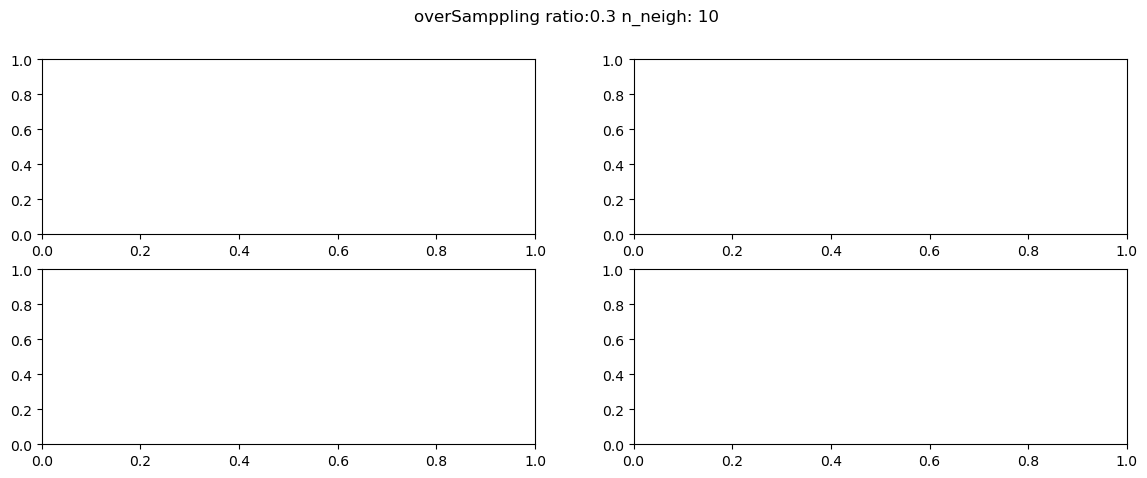

In [31]:
showLossScore(LOSS_history, Recall_history, F1score_history, specfi_history, resamp_ratio, n_neighbor)

##### test 데이터셋 모델 테스트

In [1]:
data_input = [80, "여자", 0]

# 입력 데이터 적합성 확인-----------------------------------------------------------
if len(data_input) !=3: print("나이, 성별, 발병 횟수 순으로 다시 입력하세요.")

# 

# input data 성별 전처리
gender_dict = {"남자":0,"남":0,"남성":0, "여자":1,"여":1,"여성":1}
## 성별 적합성 확인
if data_input[1] not in list(gender_dict.keys()): 
    print("성별은 [남,여] [남성,여성] [남자,여자]만 가능합니다.")

data_input[1] = gender_dict[data_input[1]]
print(data_input)

# 텐서화
dataTS = torch.FloatTensor(data_input).reshape(1,-1)
print(dataTS, dataTS.shape)

# test data 예측
model.eval()
with torch.no_grad():
    pre_test = model(dataTS)
    
print("이진 분류 사망(1) 확률:", pre_test)
print("이진 분류 생존(0) 확률:", 1-pre_test)
print()
print(pre_test > weights)
print((pre_test >weights).item())

result ='사망' if (pre_test > weights).item() else '생존'
print(result)

[80, 1, 0]


NameError: name 'torch' is not defined

In [ ]:
### 데이터 로딩
DATA_FILE2 = r'./data/s41598-020-73558-3_sepsis_survival_validation_cohort.csv'

testDF = pd.read_csv(DATA_FILE2)

# 확인
testDF.tail(5)

In [26]:
testDS = SepsisDataset(testDF[testDF.columns[:-1]], testDF[[testDF.columns[-1]]])

In [ ]:
# 모델 테스트 모드 설정
model.eval()
with torch.no_grad():
    # 검증 데이터셋
    test_featrueTS=torch.FloatTensor(testDS.featureDF.values).to(DEVICE)
    test_targetTS=torch.FloatTensor(testDS.targetDF.values).to(DEVICE)
    
    # 추론/평가
    pre_test=model(test_featrueTS)

    # 손실
    loss_test=crossLoss(pre_test, test_targetTS)
    # 성능평가
    #score_val=F1Score(task='binary')(pre_test, val_targetTS)
    # 성능평가
    f1score_test=f1score_func(pre_test, test_targetTS)
    recall_test = recall_func(pre_test, test_targetTS)
    
print(f'- [TEST] LOSS : {loss_test.item()} \
      f1-SCORE : {f1score_test.item()}\
      recall: {recall_test.item()}')

In [ ]:
pre_test

In [ ]:
preds_1d = y_pred.flatten() # 차원 펴주기
pred_class = np.where(preds_1d > 0.5, 2 , 1) #0.5보다크면 2, 작으면 1

'''모델 평가'''
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
print(classification_report(y_test, pred_class))